In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("poster")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10T18:52:32.159Z,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10T18:49:23.310Z,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10T16:40:16.050Z,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10T08:28:40.129Z,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.87500,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.11900,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58103,2022-05-10 18:52:32.159000+00:00,-27.668500,-176.934500,25.08,4.60,mb,NaN,76.00,1.80900,0.7400,...,2022-05-31T22:12:12.040Z,Kermadec Islands region,earthquake,10.1,3.7,0.100,34.0,reviewed,us,us
58104,2022-05-10 18:49:23.310000+00:00,-59.013100,-25.575000,55.95,4.90,mb,NaN,65.00,7.65300,0.6000,...,2022-05-31T19:19:19.040Z,South Sandwich Islands region,earthquake,11.6,4.4,0.099,32.0,reviewed,us,us
58105,2022-05-10 16:40:16.050000+00:00,34.731833,-119.073333,11.19,0.83,ml,8.0,168.00,0.02522,0.1500,...,2022-06-07T17:55:46.520Z,"14km SSE of Pine Mountain Club, CA",earthquake,0.5,0.9,0.211,2.0,reviewed,ci,ci
58106,2022-05-10 08:28:40.129000+00:00,2.945500,128.323100,53.98,4.50,mb,NaN,100.00,2.36100,0.8200,...,2022-06-06T07:24:34.040Z,"139 km NNE of Tobelo, Indonesia",earthquake,7.0,7.8,0.111,24.0,reviewed,us,us


In [5]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource


In [6]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag
0,37.384000,-117.107500,1.10,1.30
1,38.181000,-117.818000,7.30,1.40
2,61.340700,-149.885200,30.00,1.50
3,62.870300,-150.762500,111.30,2.10
4,64.014500,-148.765700,1.90,1.50
...,...,...,...,...
58103,-27.668500,-176.934500,25.08,4.60
58104,-59.013100,-25.575000,55.95,4.90
58105,34.731833,-119.073333,11.19,0.83
58106,2.945500,128.323100,53.98,4.50


In [7]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
dtype: int64

In [8]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [9]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [10]:
#establish features to be used in model. X will use: longitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['depth'], axis = 1)

y = cleaned_df_dropped[['depth']]

In [11]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((58102, 3), (58102, 1))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [13]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 661.6031942327722, 	R2 score: 0.7650606802330515, 	Model score: 0.7650606802330515
n_estimators=3:
	Mean Squared Error: 554.0647815279984, 	R2 score: 0.8032482248971542, 	Model score: 0.8032482248971542
n_estimators=4:
	Mean Squared Error: 519.6213888955617, 	R2 score: 0.8154792831902063, 	Model score: 0.8154792831902063
n_estimators=5:
	Mean Squared Error: 496.4706701843154, 	R2 score: 0.8237002442640772, 	Model score: 0.8237002442640772
n_estimators=6:
	Mean Squared Error: 480.3076038291903, 	R2 score: 0.8294398474702327, 	Model score: 0.8294398474702327
n_estimators=7:
	Mean Squared Error: 471.1379142790449, 	R2 score: 0.8326960600220531, 	Model score: 0.8326960600220531
n_estimators=8:
	Mean Squared Error: 483.9506329818981, 	R2 score: 0.8281461856522591, 	Model score: 0.8281461856522591
n_estimators=9:
	Mean Squared Error: 475.55519661904316, 	R2 score: 0.831127456186364, 	Model score: 0.831127456186364
n_estimators=10:
	Mean Squared Error: 463

In [14]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,80):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 661.6031942327722, 	R2: 0.7650606802330515, 	Model score: 0.7650606802330515
n_estimators=3:
	Mean Squared Error: 554.0647815279984, 	R2: 0.8032482248971542, 	Model score: 0.8032482248971542
n_estimators=4:
	Mean Squared Error: 519.6213888955617, 	R2: 0.8154792831902063, 	Model score: 0.8154792831902063
n_estimators=5:
	Mean Squared Error: 496.4706701843154, 	R2: 0.8237002442640772, 	Model score: 0.8237002442640772
n_estimators=6:
	Mean Squared Error: 480.3076038291903, 	R2: 0.8294398474702327, 	Model score: 0.8294398474702327
n_estimators=7:
	Mean Squared Error: 471.1379142790449, 	R2: 0.8326960600220531, 	Model score: 0.8326960600220531
n_estimators=8:
	Mean Squared Error: 483.9506329818981, 	R2: 0.8281461856522591, 	Model score: 0.8281461856522591
n_estimators=9:
	Mean Squared Error: 475.55519661904316, 	R2: 0.831127456186364, 	Model score: 0.831127456186364
n_estimators=10:
	Mean Squared Error: 463.0125256059741, 	R2: 0.8355814349784226, 	Model 

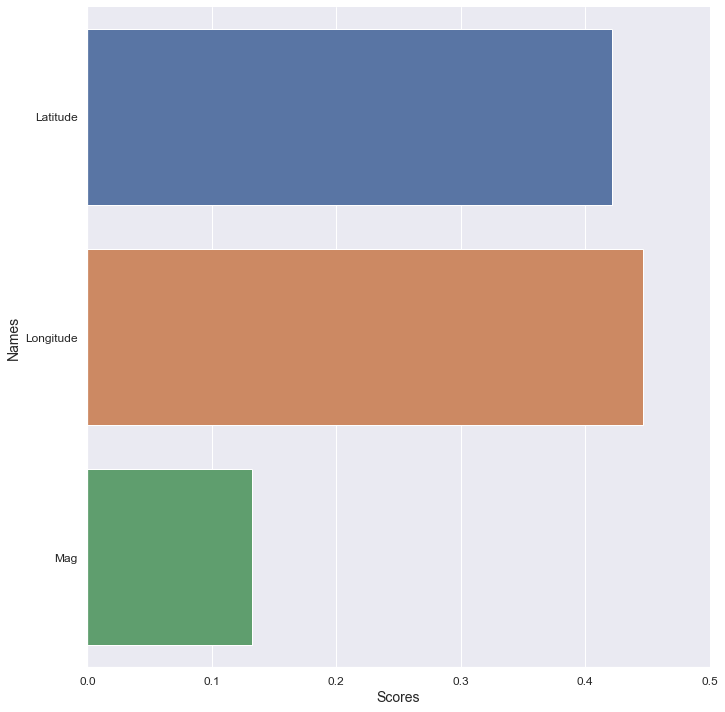

In [15]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['latitude', 'longitude', 'mag']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [16]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 5811  5812  5813 ... 58099 58100 58101] | test: [   0    1    2 ... 5808 5809 5810]
Train: [    0     1     2 ... 58099 58100 58101] | test: [ 5811  5812  5813 ... 11619 11620 11621]
Train: [    0     1     2 ... 58099 58100 58101] | test: [11622 11623 11624 ... 17429 17430 17431]
Train: [    0     1     2 ... 58099 58100 58101] | test: [17432 17433 17434 ... 23239 23240 23241]
Train: [    0     1     2 ... 58099 58100 58101] | test: [23242 23243 23244 ... 29049 29050 29051]
Train: [    0     1     2 ... 58099 58100 58101] | test: [29052 29053 29054 ... 34859 34860 34861]
Train: [    0     1     2 ... 58099 58100 58101] | test: [34862 34863 34864 ... 40669 40670 40671]
Train: [    0     1     2 ... 58099 58100 58101] | test: [40672 40673 40674 ... 46479 46480 46481]
Train: [    0     1     2 ... 58099 58100 58101] | test: [46482 46483 46484 ... 52289 52290 52291]
Train: [    0     1     2 ... 52289 52290 52291] | test: [52292 52293 52294 ... 58099 58100 58101]


In [17]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-6.54818998 -6.50600625 -6.81715544 -7.43583368 -7.474156   -6.84371048
 -6.88735309 -5.96079278 -6.83335178 -7.99592486]
MAE: -6.930 (0.546)


In [18]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [19]:
#create elements for plot validation curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

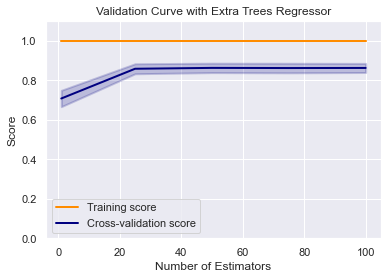

In [20]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [21]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_dep = y_test
depth = actual_dep['depth'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(depth, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 20.184
MAE: 6.835


In [22]:
#make dataframe with actual test values and ML predicted ones
dep_pred = actual_dep
dep_pred['Predicted'] = testpredict


In [23]:
dep_pred_all = dep_pred.rename(columns={'depth': 'Actual'})

In [24]:
dep_pred_all

,Actual,Predicted
3616,1.25,1.302558
13495,0.95,1.933488
28367,10.20,8.498372
31835,12.28,12.128140
27553,110.80,70.769767
...,...,...
53210,46.90,36.004651
52159,14.98,15.384186
21480,-0.48,-0.503721
44332,1.87,2.446977


In [25]:
#join dataframes for actual and predicted with original dataframe
dep_pred_all = dep_pred_all.merge(model_df, how='inner', left_index=True, right_index=True)
# lon_pred_all = lon_pred_all.rename(columns={'depth_x': 'Actual', 'depth_y': 'depth'})
dep_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
3616,1.25,1.302558,2021-12-22 11:53:28.400000+00:00,38.819833,-122.790667,1.25,1.14,md,43.0,26.00,...,2021-12-30T12:41:12.200Z,"6km NNW of The Geysers, CA",earthquake,0.13,0.21,0.209000,10.0,reviewed,nc,nc
13495,0.95,1.933488,2022-01-07 02:47:48.980000+00:00,38.824000,-122.763167,0.95,0.08,md,14.0,89.00,...,2022-01-12T00:23:11.195Z,"4km W of Cobb, CA",earthquake,0.27,0.40,0.222000,3.0,reviewed,nc,nc
28367,10.20,8.498372,2022-02-18 05:32:12.402000+00:00,38.163800,-117.914700,10.20,2.70,ml,22.0,103.56,...,2022-03-02T06:48:48.040Z,"30 km SE of Mina, Nevada",earthquake,NaN,0.70,0.230000,9.0,reviewed,nn,nn
31835,12.28,12.128140,2022-03-13 14:58:22.200000+00:00,17.972500,-66.977667,12.28,2.06,md,3.0,180.00,...,2022-03-13T15:29:41.820Z,"6 km WSW of Fuig, Puerto Rico",earthquake,2.33,1.10,0.038064,3.0,reviewed,pr,pr
27553,110.80,70.769767,2022-02-20 07:26:28.782000+00:00,62.942500,-151.285700,110.80,2.00,ml,NaN,NaN,...,2022-02-20T07:39:17.563Z,"56 km NNW of Petersville, Alaska",earthquake,NaN,1.00,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53210,46.90,36.004651,2022-04-25 18:16:17.945000+00:00,61.321200,-150.048100,46.90,1.10,ml,NaN,NaN,...,2022-04-25T18:18:43.674Z,"5 km SW of Point MacKenzie, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
52159,14.98,15.384186,2022-04-29 05:24:32.810000+00:00,33.695000,-116.742000,14.98,0.19,ml,14.0,83.00,...,2022-04-29T17:11:41.475Z,"5km SSW of Idyllwild, CA",earthquake,0.29,0.37,0.216000,5.0,reviewed,ci,ci
21480,-0.48,-0.503721,2022-02-11 21:38:34.140000+00:00,33.866333,-117.495333,-0.48,1.19,ml,46.0,46.00,...,2022-02-14T16:14:48.507Z,"3km ESE of Home Gardens, CA",quarry blast,0.30,31.61,0.109000,18.0,reviewed,ci,ci
44332,1.87,2.446977,2022-03-22 19:20:34.790000+00:00,38.813835,-122.827835,1.87,0.85,md,16.0,59.00,...,2022-03-22T19:22:11.331Z,"7km WNW of The Geysers, CA",earthquake,0.24,0.68,NaN,1.0,automatic,nc,nc


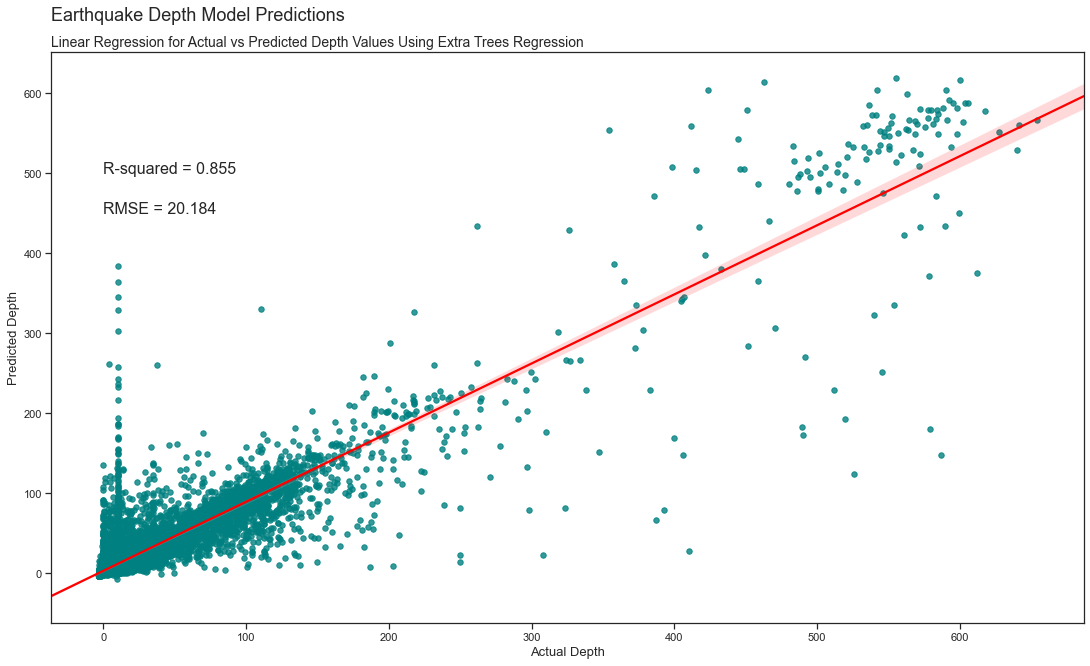

In [26]:
#plot actual vs predicted values
x = np.array(dep_pred_all['depth'])
y = np.array(testpredict)


sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Depth', fontsize=13)
plt.xlabel('Actual Depth',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Depth Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Depth Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(dep_pred_all['depth'], testpredict)), (0, 500),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 450), fontsize=16)

fig.savefig('../static/images/extratrees_depnotime_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [27]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lat = float(input('Enter a latitude (in decimal form; negative for southern hemisphere): '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
# depth = float(input('Enter a depth (in km, only numerical value): '))
# date_input = input('Enter a date (yyyy/mm/dd): ')
# time_input = input('Enter a time in UTC (HH:MM:SS): ')
# datetime_str = date_input + ' '+ time_input
# date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
# date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[lat,lon,mag]]
y_pred = best_model.predict(single_features)
print('Predicted Depth: %g' % y_pred)

Predicted Depth: 27.5444


Test with new data from USGS


In [28]:
#obtain USGS data for the day

page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-07-09T19:43:01.112Z,62.988100,-149.628600,72.10,1.10,ml,NaN,NaN,NaN,0.23,...,2022-07-09T19:45:17.245Z,"56 km SW of Cantwell, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
1,2022-07-09T19:31:50.880Z,38.780666,-122.725334,1.47,1.15,md,18.0,76.0,0.009266,0.04,...,2022-07-09T19:48:13.925Z,"3km E of The Geysers, CA",earthquake,0.27,0.47,0.040000,5.0,automatic,nc,nc
2,2022-07-09T19:10:05.280Z,19.473000,-155.650833,4.47,1.05,md,14.0,116.0,NaN,0.10,...,2022-07-09T19:49:45.680Z,"22 km E of Honaunau-Napoopoo, Hawaii",earthquake,0.41,0.98,0.136932,6.0,reviewed,hv,hv
3,2022-07-09T19:05:47.020Z,19.473500,-155.655667,5.60,1.30,md,15.0,108.0,NaN,0.09,...,2022-07-09T19:37:28.710Z,"22 km E of Honaunau-Napoopoo, Hawaii",earthquake,0.36,0.69,0.110379,7.0,reviewed,hv,hv
4,2022-07-09T19:01:51.680Z,35.993667,-117.689667,1.99,1.08,ml,15.0,124.0,0.091860,0.12,...,2022-07-09T19:05:28.691Z,"20km ENE of Little Lake, CA",earthquake,0.29,0.25,0.195000,12.0,automatic,ci,ci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,2022-07-08T20:20:45.610Z,52.095000,-176.123500,11.90,-0.53,ml,4.0,187.0,NaN,0.10,...,2022-07-09T10:46:34.480Z,"42 km NE of Adak, Alaska",earthquake,0.82,0.94,0.254350,5.0,reviewed,av,av
237,2022-07-08T20:13:54.920Z,39.429833,-110.297833,-1.95,1.80,ml,14.0,183.0,0.021880,0.15,...,2022-07-08T21:47:03.270Z,"15 km SSE of Sunnyside, Utah",earthquake,0.90,0.76,0.094000,6.0,reviewed,uu,uu
238,2022-07-08T20:07:11.670Z,33.516833,-116.453333,7.23,0.55,ml,17.0,68.0,0.024000,0.15,...,2022-07-08T20:10:48.477Z,"21km ESE of Anza, CA",earthquake,0.34,0.67,0.141000,12.0,automatic,ci,ci
239,2022-07-08T20:05:41.770Z,39.431000,-110.319000,-0.95,1.77,md,6.0,191.0,0.008355,0.04,...,2022-07-08T21:37:59.107Z,"14 km SSE of Sunnyside, Utah",earthquake,1.26,0.20,0.207000,6.0,reviewed,uu,uu


In [29]:

#dropped columns not needed
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag
0,62.988100,-149.628600,72.10,1.10
1,38.780666,-122.725334,1.47,1.15
2,19.473000,-155.650833,4.47,1.05
3,19.473500,-155.655667,5.60,1.30
4,35.993667,-117.689667,1.99,1.08
...,...,...,...,...
236,52.095000,-176.123500,11.90,-0.53
237,39.429833,-110.297833,-1.95,1.80
238,33.516833,-116.453333,7.23,0.55
239,39.431000,-110.319000,-0.95,1.77


In [30]:
#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [31]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['depth'], axis = 1)

y_test_data = cleaned_test_df[['depth']]


In [32]:
#use best model to predict data
pred_data_y = best_model.predict(X_test_data)


In [33]:
#create dataframe with predicted values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Predicted
0,62.988100,-149.628600,72.10,1.10,74.753488
1,38.780666,-122.725334,1.47,1.15,1.489070
2,19.473000,-155.650833,4.47,1.05,4.538140
3,19.473500,-155.655667,5.60,1.30,4.224419
4,35.993667,-117.689667,1.99,1.08,2.564186
...,...,...,...,...,...
236,52.095000,-176.123500,11.90,-0.53,6.954186
237,39.429833,-110.297833,-1.95,1.80,-2.887907
238,33.516833,-116.453333,7.23,0.55,9.417907
239,39.431000,-110.319000,-0.95,1.77,-1.812093


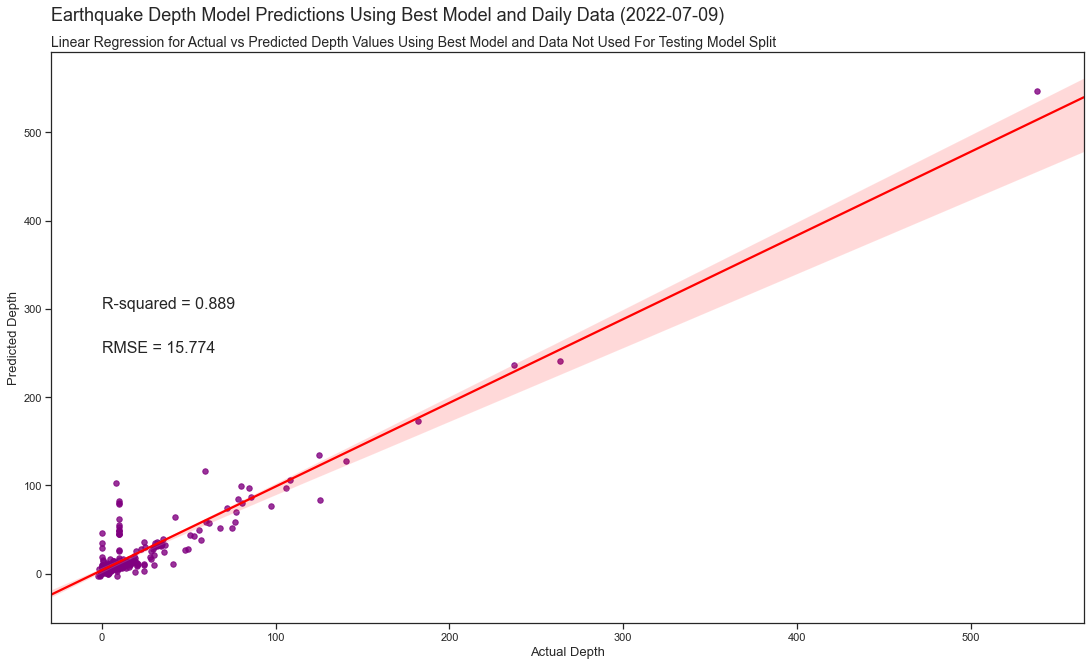

In [34]:
#create graph for actual vs predicted values
from datetime import date
today = date.today()

x = np.array(test_pred_data['depth'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)


sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Depth', fontsize=13)
plt.xlabel('Actual Depth',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Depth Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Depth Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 300),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 250), fontsize=16)

fig.savefig('../static/images/extratrees_depnotime_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()

In [35]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
dep_pred_all.to_sql('earthquake_etrees_dep_notime', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
dep_pred_all.to_sql('earthquake_etrees_dep_notime', conn, if_exists='replace', index=False)
# Close connection to SQLite database
conn.close()
connection.close()

Connected to database...
